<a href="https://colab.research.google.com/github/myhanafi/NLP-3/blob/main/Lung_X_ray_MOBILENET_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
# import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers
from google.colab import drive
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import drive
drive.mount ('/content/drive/')
COV_DIR ="/content/drive/MyDrive/MASTER-DATASETS/LUNG2/COVID/"
NORMAL_DIR="/content/drive/MyDrive/MASTER-DATASETS/LUNG2/NORMAL/"
VIRUS_DIR="/content/drive/MyDrive/MASTER-DATASETS/LUNG2/VIRUS/"


Mounted at /content/drive/


In [ ]:
def Images_details_Print_data(data, path):
  print("======== Images in:", path)
  for k,v in data.items():
    print("%s:\t%s"% (k, v))


def Images_details(path):
  files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
  data = {}
  data['image_count'] = len(files)
  data['min_width'] = 10**100
  data['max_width'] = 0
  data['min_height'] = 10**100
  data['max_height'] = 0

  for f in files:
    im = Image.open(f)
    width, height = im.size
    data['min_width'] = min (width, data['min_width'])
    data['max-width'] = max (width, data['max_height'])
    data['min_height'] = min (height, data['min_height'])
    data['max_height'] = max(height, data['max_height'])

# Images_details_Print_data(data, path)
Cimages = os.listdir(COV_DIR)
Nimages = os.listdir(NORMAL_DIR)
Vimages = os.listdir(VIRUS_DIR)

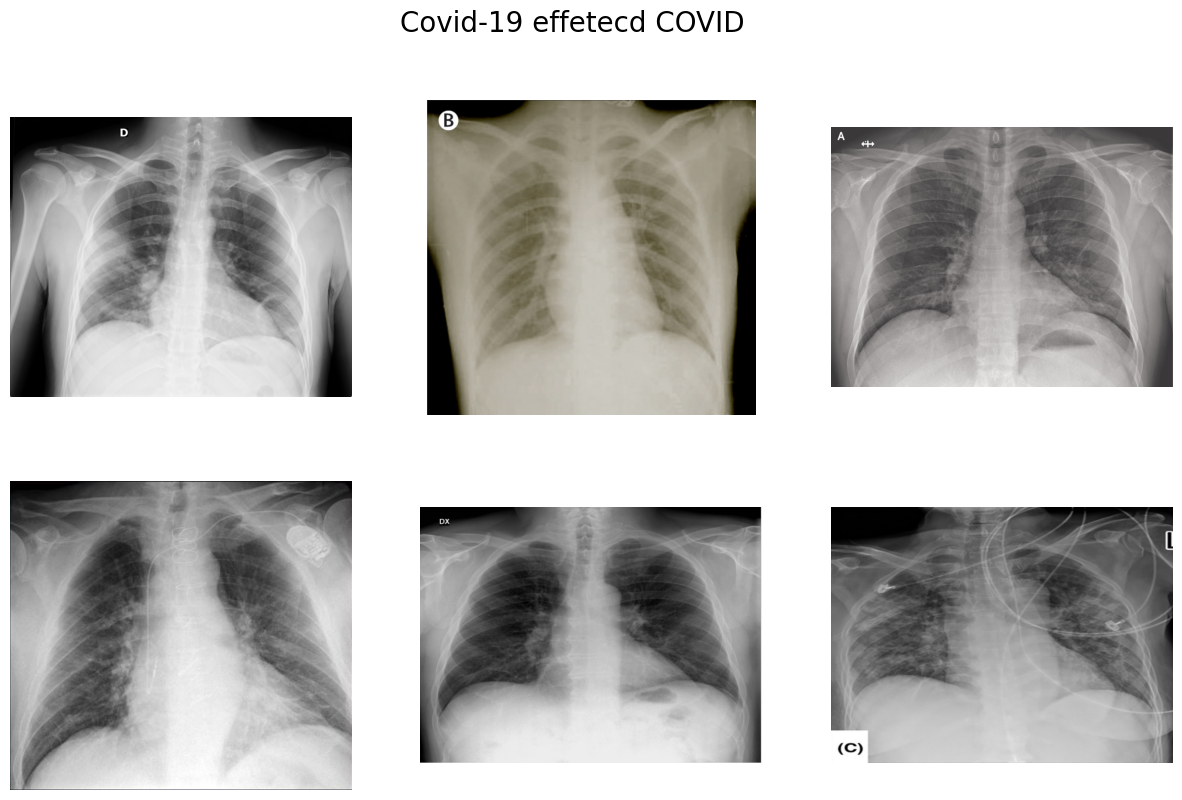

In [ ]:
sample_images = random.sample(Cimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range (0,6):
  im = cv2.imread ('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/COVID/'+sample_images[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Covid-19 effetecd COVID',fontsize=20)
plt.show()

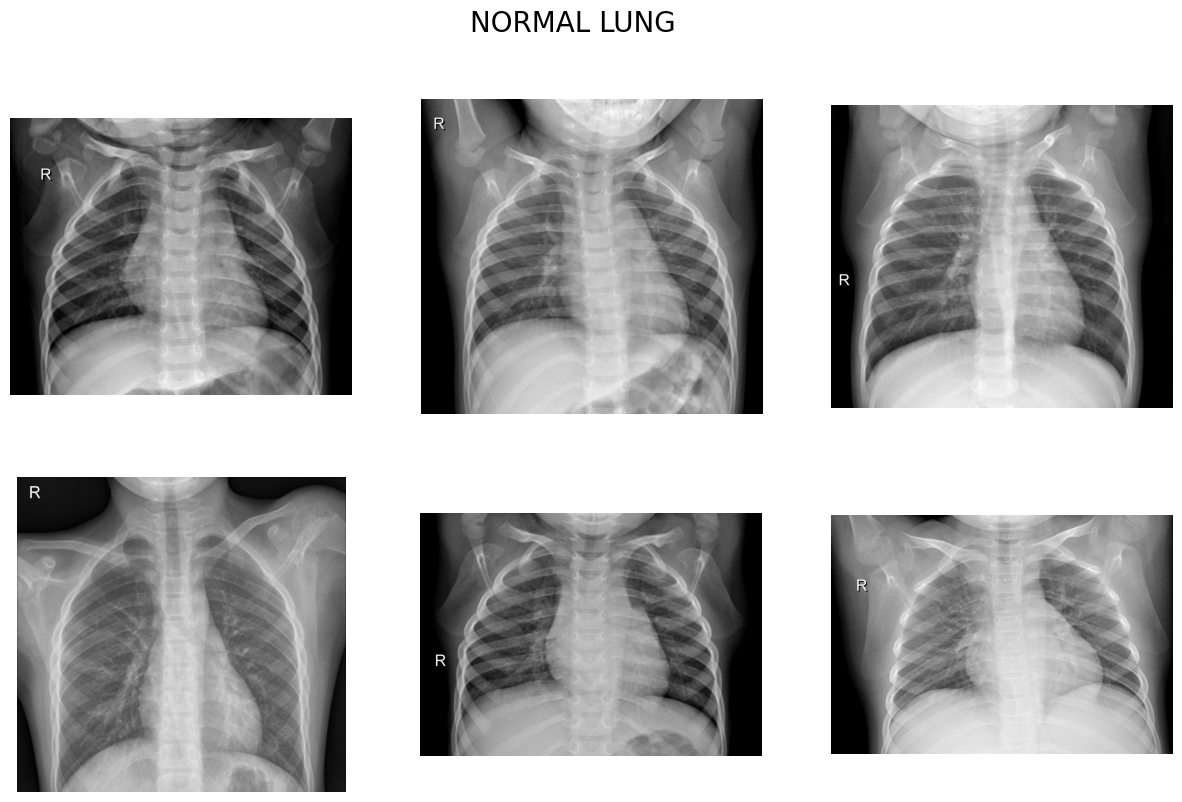

In [ ]:
sample_images = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range (0,6):
  im = cv2.imread ('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/NORMAL/'+sample_images[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('NORMAL LUNG',fontsize=20)
plt.show()

Text(0.5, 0.98, 'Covid-19 effetecd VIRUS')

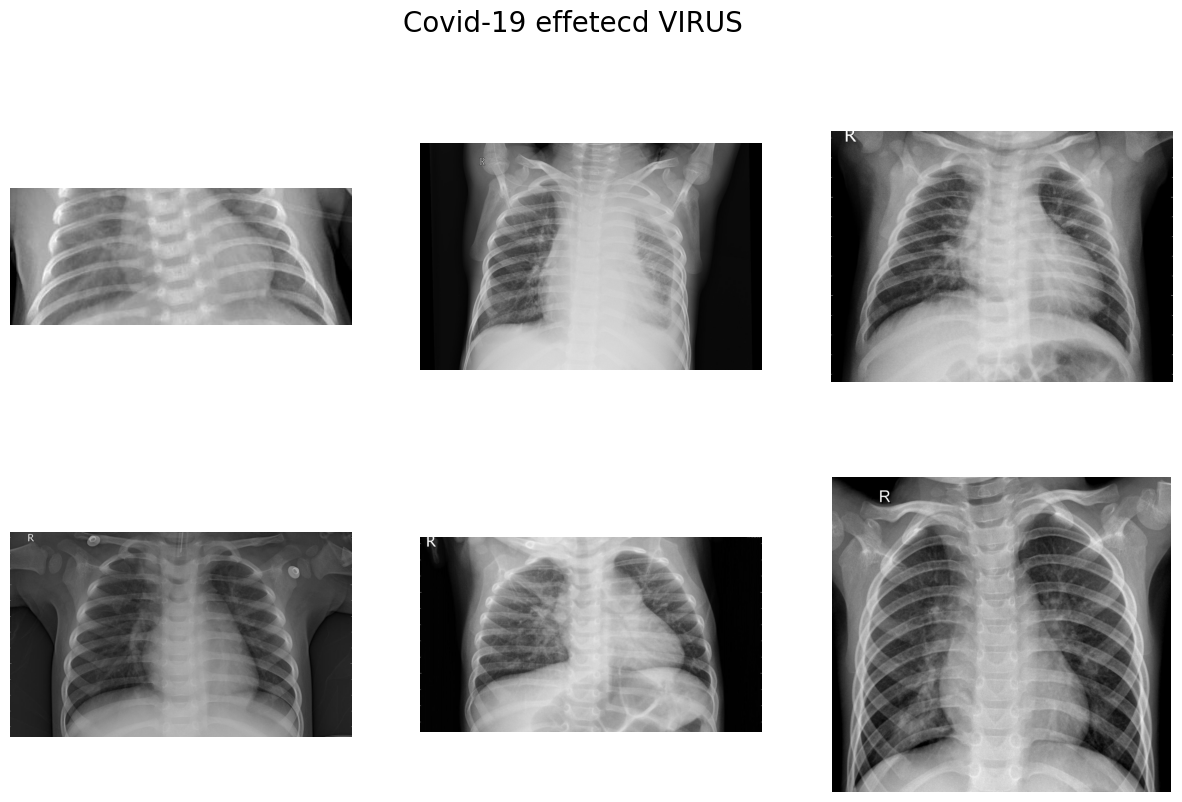

In [ ]:
sample_images = random.sample(Vimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range (0,6):
  im = cv2.imread ('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/VIRUS/'+sample_images[i])
  ax[i//3,i%3].imshow(im)
  ax[i//3,i%3].axis('off')
f.suptitle('Covid-19 effetecd VIRUS',fontsize=20)

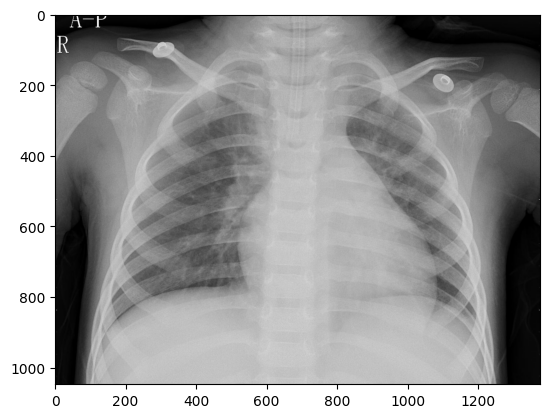

In [ ]:
img = cv2.imread('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/VIRUS/person960_virus_1633.jpeg')
plt.imshow(img, cmap=plt.cm.bone)


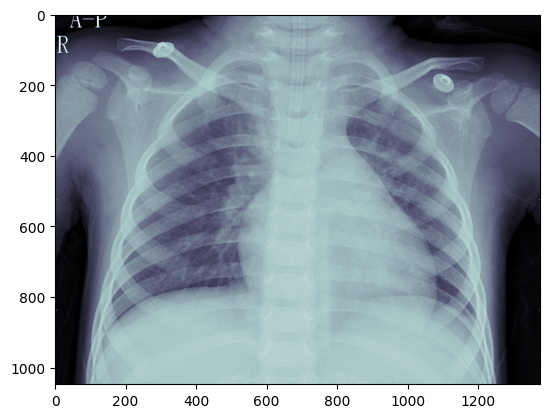

In [ ]:
def wb(channel, perc = 0.05):
  mi, ma = (np.percentile(channel, perc), np.percentile(channel, 100.0-perc))
  channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
  return channel

imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(img)])

gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap=plt.cm.bone)



In [ ]:
data=[]
labels=[]
#normal lung
Normal=os.listdir("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/NORMAL/")
for a in Normal:

  image = cv2.imread("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/NORMAL/"+a)
  imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
  gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)

  img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
  image = cv2.resize(img, (224, 224))

  data.append(image)
  labels.append(0)

  #covid
Covid=os.listdir("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/COVID/")
for b in Covid:

  image = cv2.imread("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/COVID/"+b)
  imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
  gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)

  img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
  image = cv2.resize(img, (224, 224))

  data.append(image)
  labels.append(1)

#VIRUS
Virus=os.listdir("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/VIRUS/")
for c in Virus:

  image = cv2.imread("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/VIRUS/"+c)
  imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
  gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)

  img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
  image = cv2.resize(img, (224, 224))

  data.append(image)
  labels.append(2)


In [ ]:
#transforming feature and label into array
feats=np.array(data)
labels=np.array(labels)

#save feature and label for next application

np.save("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/feats_train",feats)
np.save("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/labels_train",labels)


In [ ]:
feats=np.load("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/feats_train.npy")
labels=np.load("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/labels_train.npy")

In [ ]:
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

In [ ]:
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)


1851


In [ ]:
(x_train,x_test)=feats[(int)(0.2*len_data):], feats[:(int)(0.2*len_data)]
(y_train,y_test)=labels[(int)(0.2*len_data):], labels[:(int)(0.2*len_data)]

In [ ]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
y_train=to_categorical(y_train, 3)
y_test=to_categorical(y_test, 3)


In [ ]:
trainAug = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
os.mkdir('preview_2')
x = x_train[1]
x = x.reshape((1,) + x.shape)

i = 0
for batch in trainAug.flow(x, batch_size=1, save_to_dir='preview_2', save_prefix='aug_img', save_format='jpg'):
  i += 1
  if i > 30:
    break

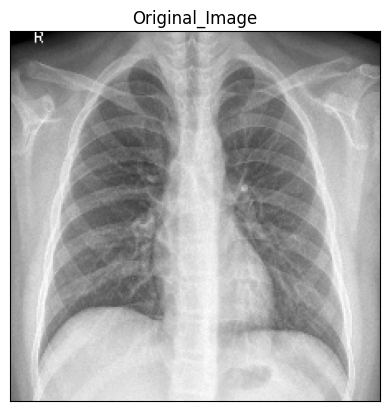

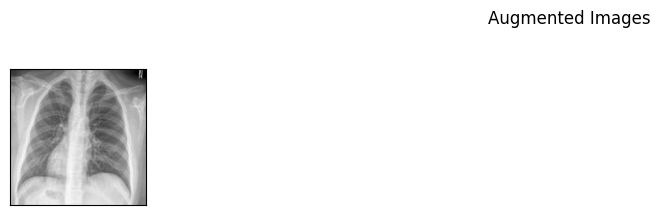

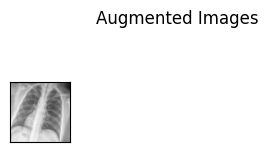

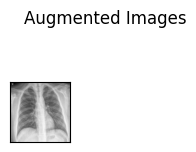

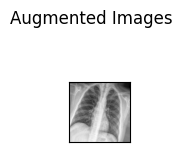

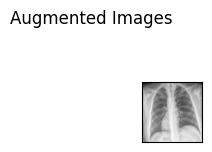

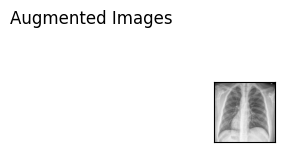

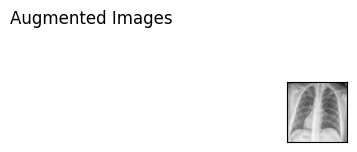

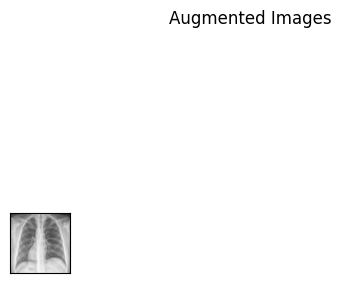

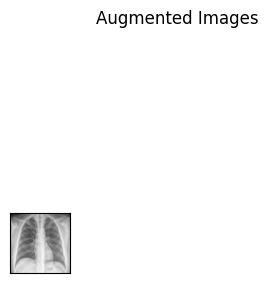

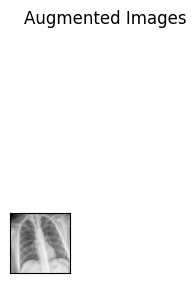

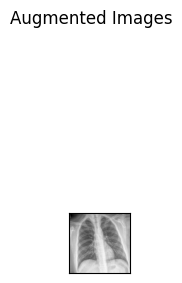

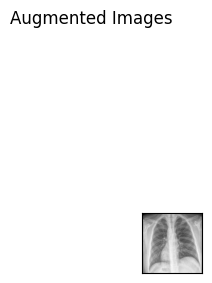

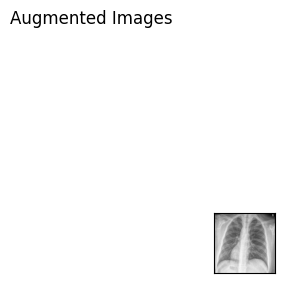

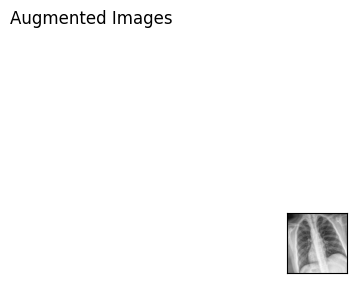

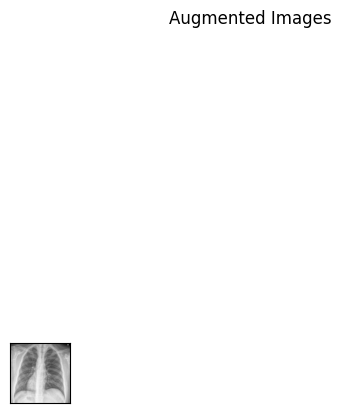

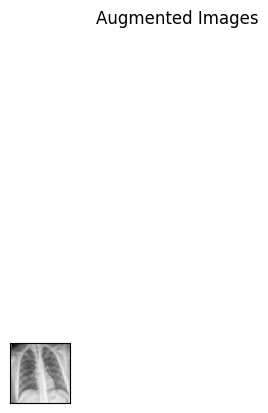

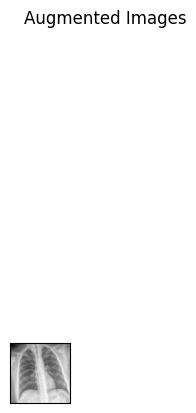

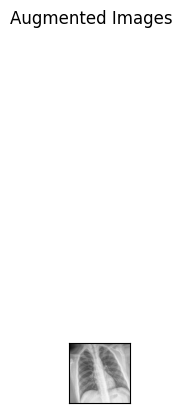

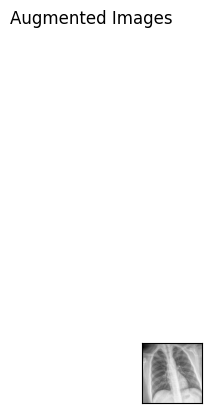

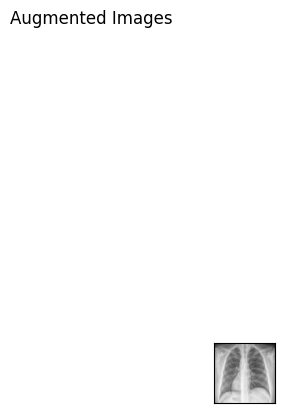

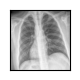

In [ ]:
plt.imshow(x_train[1])
plt.xticks([])
plt.yticks([])
plt.title('Original_Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_2/'):
    img = cv2.imread('preview_2/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
    plt.suptitle ('Augmented Images')
    plt.show()

In [ ]:
from keras.src.applications.mobilenet_v2 import MobileNetV2
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
  layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# print(conv_base.output.shape)
# pnext = next(trainAug.flow(x_train, y_train, batch_size=BS))
# pnext[1]
# len(pnext[0])

In [ ]:
x = conv_base.output

x1 = layers.Conv2D(1280, (1, 1))(x)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Reshape((256, 5))(x1)

x2 = layers.Conv2D(1280, (1, 1))(x)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Reshape((256, 5))(x2)

x = layers.Attention()([x1, x2])
x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
x = Dense (units=512, activation='relu')(x)
x = Dropout (rate=0.7)(x)
x = Dense (units=128, activation='relu')(x)
x = Dropout (rate=0.5)(x)
x = Dense (units=64, activation='relu')(x)
x = Dropout (rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout (rate=0.3)(x)
prediction = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 5,745,027 (21.92 MB)

 Trainable params: 3,487,043 (13.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
callbacks = [ModelCheckpoint('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/MOBILENET-CLAHE-3CLASSES.keras', monitor='val_loss',mode='min', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, model='min', min_lr=0.000000000001 )]



In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
BS = 32
print("[INFO] training head.....")
H = model.fit(
    trainAug.flow(x_train, y_train, batch_size=BS),
   # steps_per_epoch=train_len // BS,
    validation_data=(x_test, y_test),
   # validation_steps=test_len // BS,
    epochs=100,callbacks=callbacks)

[INFO] training head.....
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8886 - loss: 0.3546
Epoch 1: val_loss did not improve from 0.20944
47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 751ms/step - accuracy: 0.8888 - loss: 0.3538 - val_accuracy: 0.8865 - val_loss: 0.4457 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9014 - loss: 0.3884
Epoch 2: val_loss did not improve from 0.20944
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 735ms/step - accuracy: 0.9015 - loss: 0.3872 - val_accuracy: 0.9189 - val_loss: 0.2789 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.9336 - loss: 0.2149
Epoch 3: val_loss did not improve from 0.20944
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 732ms/step - accuracy: 0.9334 - loss: 0.2156 - val_accuracy: 0.8649 - val_loss: 0.3849 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9205 - loss: 0.2376
Epoch 4: val_loss did not improve from 0.20944

Epoch 4: ReduceLROnPlateau reducing learning rate

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs_range = range(1, len(H.epoch) + 1)

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Mobilenet Attention Model Accuracy')



plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mobilenet Attention Model Loss')
plt.tight_layout()
plt.show()

NameError: name 'H' is not defined

In [ ]:
model = load_model ('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/MOBILENET-CLAHE-3CLASSES.keras')
model.save('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/model_v1.h5')
model = load_model('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/model_v1.h5')

accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - accuracy: 0.9323 - loss: 0.1785

 Test_Accuracy:- 0.9351351261138916


In [ ]:
model = load_model ('/content/drive/MyDrive/MASTER-DATASETS/LUNG2/model_v1.h5')
rounded_predictions = model.predict(x_test, batch_size = 16, verbose=0)
rounded_predictions[1]

array([1.02664735e-02, 3.13502824e-04, 9.89420056e-01], dtype=float32)

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step


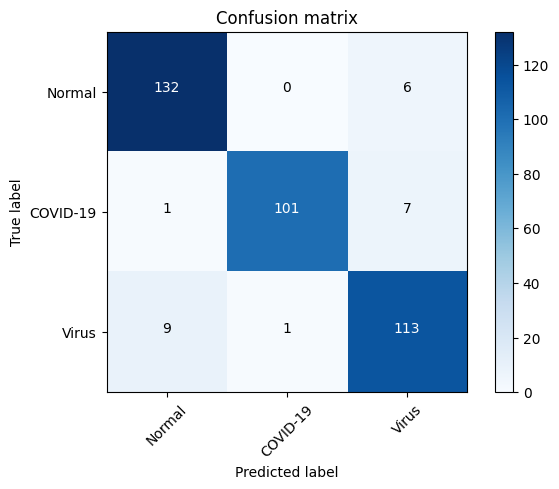

In [ ]:
#ori dari web
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    target_names =['Normal','COVID-19','Virus']
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Predict the values from the validation dataset
pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y,axis=1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [ ]:
predIdxs = model.predict(x_test, batch_size=BS)

predIdxs = np.argmax (predIdxs, axis=1)
rounded_labels=np.argmax (y_test, axis=1)

print (classification_report(rounded_labels, predIdxs, target_names=['NORMAL','COVID', 'VIRUS']))


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 438ms/step
              precision    recall  f1-score   support

      NORMAL       0.93      0.96      0.94       138
       COVID       0.99      0.93      0.96       109
       VIRUS       0.90      0.92      0.91       123

    accuracy                           0.94       370
   macro avg       0.94      0.93      0.94       370
weighted avg       0.94      0.94      0.94       370



24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step


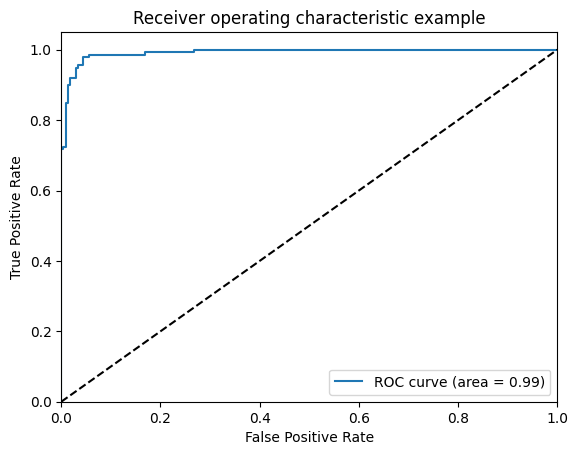

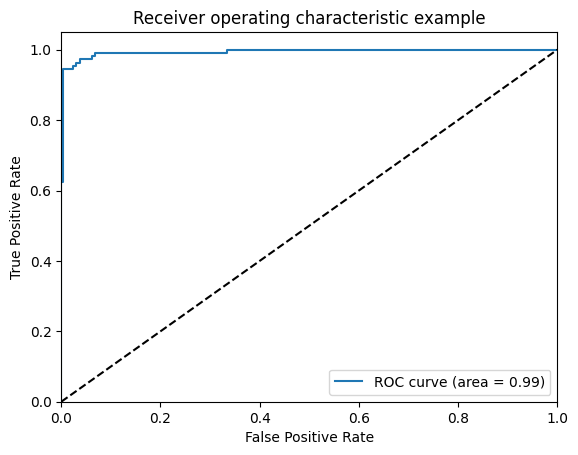

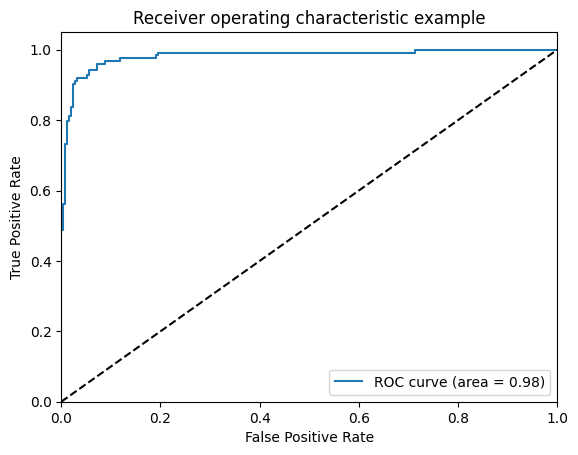

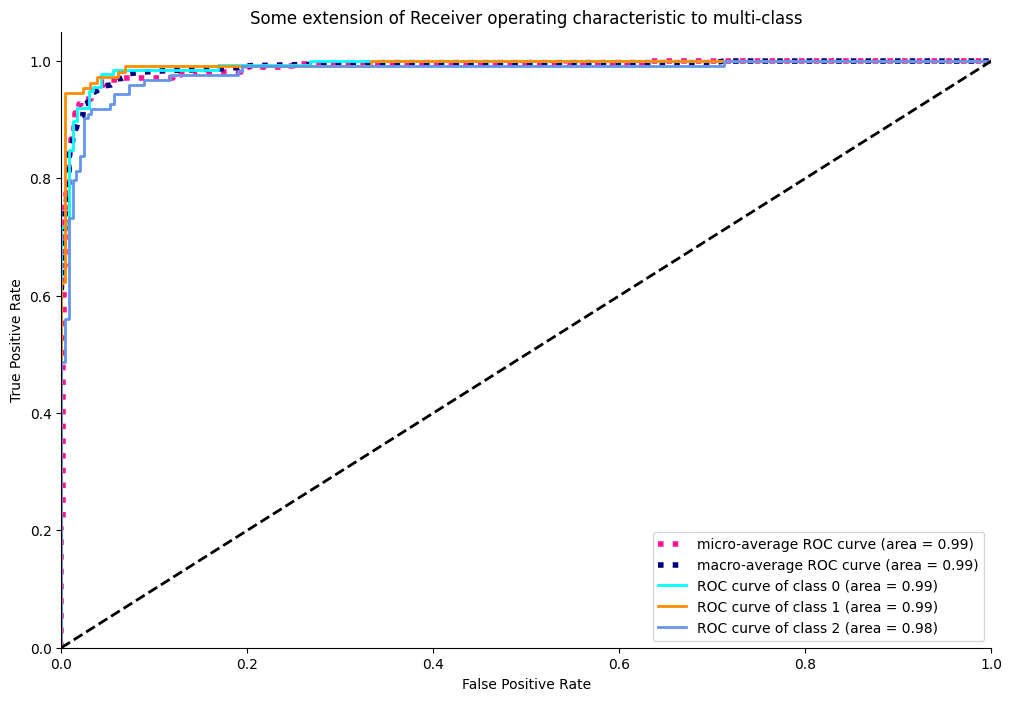

In [ ]:
#ori dari web
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
#from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_test = np.array(y_test)
n_classes = 3
pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

In [ ]:
#Heat map GRAD-CAM dari web

import tensorflow as tf
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    # fname=img_path.split('.')[-1]
    file_name=os.path.basename(img_path)
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    # img = im.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

    # # Preprocessing the image
    # img = im.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    # img = img.astype('float32')/255
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    file_name=file_name+"_"+cam_path
    basepath = os.path.dirname(__file__)
    cam_path = os.path.join(
            basepath, 'uploads', secure_filename(file_name))
    # Save the superimposed image


    superimposed_img.save(cam_path)
    # Display Grad CAM
    display(Image(cam_path))


# predict function with image preprocessing
def image_preprocess(img_path):
    img_size=(224,224)
    img = cv2.imread("/content/drive/MyDrive/MASTER-DATASETS/LUNG2/VIRUS/person960_virus_1633.jpeg")
    # Preprocessing the image

    imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(img)] )
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(img, (224, 224))
    # Preprocessing the image
    img = np.array(image)
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32')/255


    return img

In [ ]:
last_conv_layer_name = "block_16_deptwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

In [ ]:
import tensorflow as tf
def get_img_array (img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  with tf.GradientTape() as tape:
    last_conv_layer_putput, preds = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grad = tf.reduce_mean(grads, axis(0, 1, 2))

    last_conv_layer_output = last_conv_later_output[0]
    heatmap = last_conv_output @ pooled_grads[.... tf.newaxis]
    heatmap = tf.squeeze (heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

#preparing image
imag_size = (224,224)
image = cv2.imread("/content/drive/MyDrive/LUNG-DISEASES/COVID/COVID-1055.png")
imWB = np.dstack([wb(channel, 0.05)for channel in cv2.split(image)])
gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)

img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
image = cv2.resize(img, (224, 224))

#pre-processing image
img = np.array(image)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

#removing last layer image
model.layers[-1].activation = None

#showing what the top predicted class
preds = model.predict(img)

#generate class activation heatmap
last_conv_layer_name = "block_16_deptwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
#Display grad-cam model
plt.matshow(heatmap)
plt.show()


In [ ]:
img_path="/content/drive/MyDrive/LUNG-DISEASES/COVID/COVID-1055.png"
display(Image(img_path))

In [ ]:
from Ipython.display import image, display
from tensorflow.keras.preprocessing import image as im
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

def save_and_display_gradcam(img_path, heatmap, cam_path="/content/drive/MyDrive/LUNG-DISEASES/cam.jpg", alpha=0.4):
  #load image original
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  heatmap = np.uint8(255 = heatmap)

  jet = cm.get.cmap("jet")

  jet_colors = jet(np.arrange(256))[:,13]
  jet_heatmap = jet_color[heatmap]

  #developed image with RGB
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.imahe.img_to_array(jet_heatmap)

  #superimpose heatmap
  superimposed_img = jet_heatmap = alpha + img
  superimposed_img = tf.keras.preprocessing.image.array(superimposed_img)

  #save super impoased image
  superimposed_img.save(cam_path)

  #display gradcam
  display(Image(cam_path))

In [ ]:
from IPython.display import Image, display
img_path1="/content/drive/MyDrive/LUNG-DISEASES/COVID/COVID-1055.png"
display(image(img_path1))

In [ ]:
def wb(channel, perc = 0.05):
  mi, ma = (np.percentile(channel, perc), np.percentile(channel, 100.0.perc))
  channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi)))
  return channel

In [ ]:
image = cv2.imread(img_path1)

imWB = np.dstack ([wb(channel, 0.05)for channel in cv2.split(image)])
gray_image = cv2.cvtcolor (imWB, cv2.COLOR_BGR2GRAY)

img = cv2.cvtcolor(gray_image, cv2.COLOR_BGR2GRAY)

img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)

image =cv2.resize(img,(224, 224))

#pre-processing image
img = np.array(image)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

last_conv_layer_name ="block_16_deptwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
save and display_graddam(img_path1, heatmap)


In [ ]:
img_path2 = "/content/drive/MyDrive/LUNG-DISEASES/NORMAL/Normal-10080.png"
display(Image(img_path2))


In [ ]:
image1 = cv2.imread(img_path2)
imWB = np.dstack([wb(channel, 0.05)for channel in cv2.split(image1)])
gray_image1 = cv2.cvtColor(imWB, cv2.COLOR_BGR2RGB)

img = cv2.cvtColor(gray_image1, cv2, COLOR_GRAY2RGB)
image1 = cv2.resize(img, (224, 224))

img1 = np.array(image1)
img2 = np.expand_dims(img, axis=0)
img2 = img2.astype(float32)/255

last_conv_layer_name = "block_16_deptwise"
heatmap = make_gradcam_heatmap(img2, model, last_conv_layer_name)
save_and_display_gradcam(img_path2, heatmap)